In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

class SpectrogramDataset(Dataset):
    def __init__(self, spectro_folder):
        self.spectrogram_folders = list(spectro_folder.glob('spectrogram_*'))
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: torch.flatten(x)),
        ])

    def __len__(self):
        return len(self.spectrogram_folders)

    def __getitem__(self, idx):
        folder_path = self.spectrogram_folders[idx]

        # Load the spectrogram image
        img = Image.open(folder_path / 'spectrogram.png') #.convert('L')
        img = self.transform(img)

        # Load the label
        label_path = folder_path / 'label.txt'
        with open(label_path, 'r') as label_file:
            label = int(label_file.read().strip())

        return img, label

# Path to the folder containing your spectrograms
spectro_folder = Path('./spectrograms')

# Create a custom dataset
Data = SpectrogramDataset(spectro_folder)
dataloader = DataLoader(Data, batch_size = len(Data))

In [7]:
for batch_idx, (images, labels) in enumerate(dataloader):
    print(f"Training SVM for batch {batch_idx + 1}/{len(dataloader)}...")
    images = np.asarray(images)
    labels = np.asarray(labels)
    
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels)
    
    classifier = SVC(probability=True)

    param_grid={'C':[0.1,10], 
            'gamma':[0.01,0.1], 
            'kernel':['rbf','poly']} 

    model = GridSearchCV(classifier, param_grid)

    model.fit(x_train, y_train)


    # Evaluate the final model
    y_pred = model.predict(x_test)
    print(f"The model is {accuracy_score(y_pred, y_test) * 100}% accurate")

Training SVM for batch 1/1...
The model is 68.0161943319838% accurate


In [8]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['sleep stage W', 'sleep Stage 1', 'sleep Stage 2', 'Sleep Stage 3/4', 'Sleep Stage R']))

                 precision    recall  f1-score   support

  sleep stage W       0.62      0.72      0.67        40
  sleep Stage 1       0.32      0.27      0.30        33
  sleep Stage 2       0.82      0.86      0.84       124
Sleep Stage 3/4       0.56      0.45      0.50        11
  Sleep Stage R       0.55      0.46      0.50        39

       accuracy                           0.68       247
      macro avg       0.57      0.56      0.56       247
   weighted avg       0.67      0.68      0.67       247



In [ ]:
# for batch_idx, (images, labels) in enumerate(dataloader):
#     print(f"Training SVM for batch {batch_idx + 1}/{len(dataloader)}...")
#     images = np.asarray(images)
#     labels = np.asarray(labels)
#     x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=77,)
    
#     classifier = SVC(probability=True)

#     param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.1, 1], 'kernel': ['rbf', 'poly']}

#     model = GridSearchCV(classifier, param_grid)

#     model.fit(x_train, y_train)

#     y_pred = model.predict(x_test)
    
#     print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.8)
pca.fit(x_train)
# print(pca.explained_variance_ratio_)
fig, axes = plt.subplots(2,10,figsize=(9,3),
 subplot_kw={'xticks':[], 'yticks':[]},
 gridspec_kw=dict(hspace=0.01, wspace=0.01))
for i, ax in enumerate(axes.flat):
 ax.imshow(pca.components_[i].reshape(64,64),cmap='gray')
converted_data = pca.fit_transform(x_train)

In [ ]:
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 50,
            cmap = c_map , c = y_train)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show()

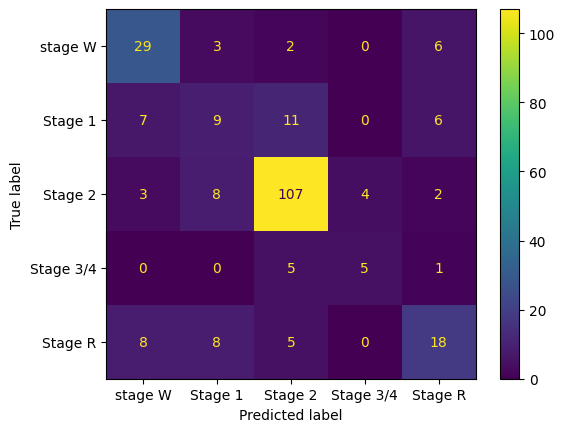

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["stage W", "Stage 1", "Stage 2", "Stage 3/4", "Stage R"])
disp.plot()
plt.show()
